In [24]:
# Imports cell with respect to the pytorch library.
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd

In [25]:
# CNN Model Definition and architecture
class SimpleCNN(nn.Module):
    def __init__(self, num_classes, dropout):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 16 * 16, 512)  # was 128 * 8 * 8
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)

        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)

        x = self.relu(self.bn5(self.conv5(x)))
        x = self.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)

        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [26]:
# Data Transforms and Loading
transform_train = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)), 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5375, 0.4891, 0.4224],
                         std=[0.1923, 0.1820, 0.1725])
])

# Validation and testing should also be 128x128, matching the network:
transform_val = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5375, 0.4891, 0.4224],
                         std=[0.1923, 0.1820, 0.1725])
])

dataset_root = r"C:\Users\yozev\OneDrive\Desktop\artFiltered"
full_dataset = ImageFolder(root=dataset_root, transform=transform_train)

# Dataset Splitting (unchanged)
batch_size = 16
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

dataset_size = len(full_dataset)
train_size = int(0.75 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(seed)
)

# Update the transforms for validation and test sets to 128x128
val_dataset.dataset.transform = transform_val
test_dataset.dataset.transform = transform_val

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


In [27]:
# Dataset Splitting

batch_size = 32
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

dataset_size = len(full_dataset)
train_size = int(0.75 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(seed)
)

# Change the transforms of validation and test sets
val_dataset.dataset.transform = transform_val
test_dataset.dataset.transform = transform_val

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [28]:
#  Model Initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=len(full_dataset.classes), dropout=0.5).to(device)

In [29]:
# Loss, Optimizer, Scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [30]:
# Training Loop

epochs = 100
best_val_loss = float('inf')
patience = 10
patience_counter = 0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    train_loop = tqdm(train_loader, desc=f"Epoch [{epoch + 1}/{epochs}]")
    for images, labels in train_loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        train_loop.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        val_loop = tqdm(val_loader, desc="Validation")
        for images, labels in val_loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            val_loop.set_postfix(loss=loss.item())

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct_val / total_val

    
    scheduler.step(avg_val_loss)

    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Print metrics for this epoch
    print(f"Epoch [{epoch+1}/{epochs}] -> "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': best_val_loss,
        }, 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

Validation: 100%|██████████| 304/304 [00:13<00:00, 23.03it/s, loss=2.28]


Epoch [1/100] -> Train Loss: 2.3096, Train Acc: 0.1927 | Val Loss: 2.1372, Val Acc: 0.2633


Validation: 100%|██████████| 304/304 [00:13<00:00, 22.67it/s, loss=1.96]


Epoch [2/100] -> Train Loss: 2.1359, Train Acc: 0.2600 | Val Loss: 1.9888, Val Acc: 0.3242


Validation: 100%|██████████| 304/304 [00:13<00:00, 22.74it/s, loss=1.98]


Epoch [3/100] -> Train Loss: 2.0464, Train Acc: 0.2926 | Val Loss: 1.9366, Val Acc: 0.3365


Validation: 100%|██████████| 304/304 [00:13<00:00, 22.39it/s, loss=2.04]


Epoch [4/100] -> Train Loss: 1.9669, Train Acc: 0.3201 | Val Loss: 1.9132, Val Acc: 0.3465


Validation: 100%|██████████| 304/304 [00:13<00:00, 22.41it/s, loss=1.86]


Epoch [5/100] -> Train Loss: 1.9036, Train Acc: 0.3406 | Val Loss: 1.8149, Val Acc: 0.3844


Validation: 100%|██████████| 304/304 [00:13<00:00, 22.35it/s, loss=1.92]


Epoch [6/100] -> Train Loss: 1.8452, Train Acc: 0.3635 | Val Loss: 1.8039, Val Acc: 0.3847


Validation: 100%|██████████| 304/304 [00:13<00:00, 22.41it/s, loss=1.78]


Epoch [7/100] -> Train Loss: 1.7868, Train Acc: 0.3863 | Val Loss: 1.7645, Val Acc: 0.4056


Validation: 100%|██████████| 304/304 [00:13<00:00, 22.78it/s, loss=2]   


Epoch [8/100] -> Train Loss: 1.7316, Train Acc: 0.4061 | Val Loss: 1.7444, Val Acc: 0.4120


Validation: 100%|██████████| 304/304 [00:13<00:00, 22.53it/s, loss=1.97]


Epoch [9/100] -> Train Loss: 1.6706, Train Acc: 0.4283 | Val Loss: 1.7241, Val Acc: 0.4178


Validation: 100%|██████████| 304/304 [00:13<00:00, 22.35it/s, loss=1.83]


Epoch [10/100] -> Train Loss: 1.6209, Train Acc: 0.4458 | Val Loss: 1.7203, Val Acc: 0.4291


Validation: 100%|██████████| 304/304 [00:13<00:00, 22.66it/s, loss=1.93]


Epoch [11/100] -> Train Loss: 1.5684, Train Acc: 0.4611 | Val Loss: 1.6596, Val Acc: 0.4377


Validation: 100%|██████████| 304/304 [00:13<00:00, 22.80it/s, loss=2.01]


Epoch [12/100] -> Train Loss: 1.5149, Train Acc: 0.4796 | Val Loss: 1.6148, Val Acc: 0.4551


Validation: 100%|██████████| 304/304 [00:13<00:00, 22.64it/s, loss=1.89]


Epoch [13/100] -> Train Loss: 1.4636, Train Acc: 0.4947 | Val Loss: 1.6296, Val Acc: 0.4552


Validation: 100%|██████████| 304/304 [00:13<00:00, 22.31it/s, loss=1.91] 


Epoch [14/100] -> Train Loss: 1.4170, Train Acc: 0.5121 | Val Loss: 1.6090, Val Acc: 0.4610


Validation: 100%|██████████| 304/304 [00:13<00:00, 22.30it/s, loss=2.06] 


Epoch [15/100] -> Train Loss: 1.3715, Train Acc: 0.5273 | Val Loss: 1.5893, Val Acc: 0.4708


Validation: 100%|██████████| 304/304 [00:13<00:00, 22.62it/s, loss=1.76] 


Epoch [16/100] -> Train Loss: 1.3149, Train Acc: 0.5476 | Val Loss: 1.5809, Val Acc: 0.4742


Validation: 100%|██████████| 304/304 [00:13<00:00, 22.22it/s, loss=2.22] 


Epoch [17/100] -> Train Loss: 1.2660, Train Acc: 0.5627 | Val Loss: 1.6331, Val Acc: 0.4612


Validation: 100%|██████████| 304/304 [00:13<00:00, 21.93it/s, loss=1.75] 


Epoch [18/100] -> Train Loss: 1.2146, Train Acc: 0.5812 | Val Loss: 1.6242, Val Acc: 0.4692


Validation: 100%|██████████| 304/304 [00:13<00:00, 22.40it/s, loss=1.92] 


Epoch [19/100] -> Train Loss: 1.1649, Train Acc: 0.5937 | Val Loss: 1.5851, Val Acc: 0.4808


Validation: 100%|██████████| 304/304 [00:13<00:00, 22.19it/s, loss=1.98] 


Epoch [20/100] -> Train Loss: 1.1151, Train Acc: 0.6133 | Val Loss: 1.6927, Val Acc: 0.4614


Validation: 100%|██████████| 304/304 [00:13<00:00, 22.14it/s, loss=2.25] 


Epoch [21/100] -> Train Loss: 1.0638, Train Acc: 0.6295 | Val Loss: 1.6395, Val Acc: 0.4771


Validation: 100%|██████████| 304/304 [00:13<00:00, 21.87it/s, loss=1.9]  


Epoch [22/100] -> Train Loss: 1.0190, Train Acc: 0.6482 | Val Loss: 1.5865, Val Acc: 0.4906


Validation: 100%|██████████| 304/304 [00:14<00:00, 21.41it/s, loss=2.07] 


Epoch [23/100] -> Train Loss: 0.8463, Train Acc: 0.7078 | Val Loss: 1.5718, Val Acc: 0.5036


Validation: 100%|██████████| 304/304 [00:13<00:00, 22.26it/s, loss=2.15] 


Epoch [24/100] -> Train Loss: 0.7851, Train Acc: 0.7296 | Val Loss: 1.5793, Val Acc: 0.5031


Validation: 100%|██████████| 304/304 [00:13<00:00, 22.14it/s, loss=2.4]  


Epoch [25/100] -> Train Loss: 0.7402, Train Acc: 0.7454 | Val Loss: 1.6156, Val Acc: 0.5000


Validation: 100%|██████████| 304/304 [00:13<00:00, 22.36it/s, loss=2.47] 


Epoch [26/100] -> Train Loss: 0.6873, Train Acc: 0.7637 | Val Loss: 1.6180, Val Acc: 0.5018


Validation: 100%|██████████| 304/304 [00:13<00:00, 22.47it/s, loss=2.25] 


Epoch [27/100] -> Train Loss: 0.6573, Train Acc: 0.7740 | Val Loss: 1.6382, Val Acc: 0.5058


Validation: 100%|██████████| 304/304 [00:13<00:00, 22.31it/s, loss=2.4]  


Epoch [28/100] -> Train Loss: 0.6174, Train Acc: 0.7873 | Val Loss: 1.6828, Val Acc: 0.5016


Validation: 100%|██████████| 304/304 [00:16<00:00, 18.97it/s, loss=2.18] 


Epoch [29/100] -> Train Loss: 0.5805, Train Acc: 0.7988 | Val Loss: 1.7155, Val Acc: 0.4971


Validation: 100%|██████████| 304/304 [00:19<00:00, 15.51it/s, loss=2.67] 


Epoch [30/100] -> Train Loss: 0.4814, Train Acc: 0.8407 | Val Loss: 1.7432, Val Acc: 0.5038


Validation: 100%|██████████| 304/304 [00:18<00:00, 16.09it/s, loss=2.44] 


Epoch [31/100] -> Train Loss: 0.4532, Train Acc: 0.8520 | Val Loss: 1.7500, Val Acc: 0.5042


Validation: 100%|██████████| 304/304 [00:19<00:00, 15.44it/s, loss=2.46] 


Epoch [32/100] -> Train Loss: 0.4281, Train Acc: 0.8612 | Val Loss: 1.7409, Val Acc: 0.5059


Validation: 100%|██████████| 304/304 [00:19<00:00, 15.49it/s, loss=2.6]  

Epoch [33/100] -> Train Loss: 0.4078, Train Acc: 0.8678 | Val Loss: 1.8039, Val Acc: 0.5058
Early stopping triggered.


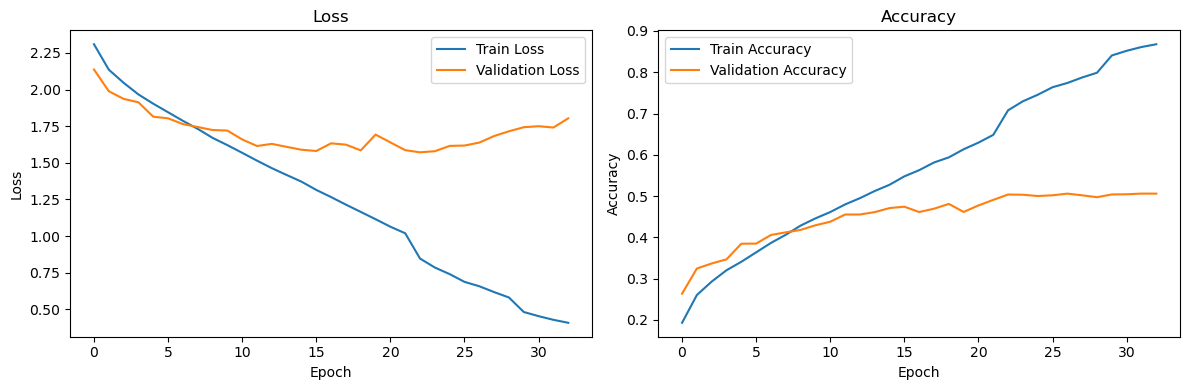

In [31]:
#  Plots of the training part

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [32]:
# Model Testing

checkpoint = torch.load('best_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

C:\Users\yozev\AppData\Local\Temp\ipykernel_21128\1799925879.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth', map_location=devic

In [33]:
# Metrics Computation
accuracy = accuracy_score(all_labels, all_predictions)
recall_per_class = recall_score(all_labels, all_predictions, average=None, zero_division=0)
precision_per_class = precision_score(all_labels, all_predictions, average=None, zero_division=0)
macro_recall = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
macro_precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)

print(f"Test Set Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro-Recall: {macro_recall:.4f}")
print(f"Macro-Precision: {macro_precision:.4f}")

for i, class_name in enumerate(full_dataset.classes):
    print(f"\nClass {class_name}:")
    print(f"Recall: {recall_per_class[i]:.4f}")
    print(f"Precision: {precision_per_class[i]:.4f}")

# Classification report
report_dict = classification_report(
    all_labels,
    all_predictions,
    target_names=full_dataset.classes,
    zero_division=0,
    output_dict=True
)
report_df = pd.DataFrame(report_dict).transpose()

print("\nClassification Report:")
print(report_df)


Test Set Results:
Accuracy: 0.5120
Macro-Recall: 0.5138
Macro-Precision: 0.5197

Class Abstract_Expressionism:
Recall: 0.6217
Precision: 0.7288

Class Art_Nouveau_Modern:
Recall: 0.4630
Precision: 0.4828

Class Baroque:
Recall: 0.6371
Precision: 0.5647

Class Cubism:
Recall: 0.6998
Precision: 0.6152

Class Expressionism:
Recall: 0.2763
Precision: 0.3114

Class Impressionism:
Recall: 0.4657
Precision: 0.4434

Class Naive_Art_Primitivism:
Recall: 0.5331
Precision: 0.5373

Class Northern_Renaissance:
Recall: 0.6345
Precision: 0.7315

Class Post_Impressionism:
Recall: 0.4266
Precision: 0.3403

Class Realism:
Recall: 0.4175
Precision: 0.3882

Class Rococo:
Recall: 0.6447
Precision: 0.6950

Class Romanticism:
Recall: 0.4479
Precision: 0.4851

Class Symbolism:
Recall: 0.4112
Precision: 0.4326

Classification Report:
                        precision    recall  f1-score      support
Abstract_Expressionism   0.728774  0.621730  0.671010   497.000000
Art_Nouveau_Modern       0.482759  0.463035  